In [31]:
import math
import sys
sys.path.append('UniverSeg')
from example_data.wbc import WBCDataset
import itertools
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import einops as E
import torch
from universeg import universeg
from collections import defaultdict
from argparse import ArgumentParser
import zipfile
import os
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset
from PIL import Image

In [59]:
device = f'cuda:3' if torch.cuda.is_available() else 'cpu'

model = universeg(pretrained=True)
_ = model.to(device)

def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}


# helpful function to sample support data
def sample_support(seed,support_size,d_support):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels


In [7]:
with zipfile.ZipFile('./HAM10000_images_part_1.zip', 'r') as zip_ref:
    zip_ref.extractall('HAM10k')
with zipfile.ZipFile('./HAM10000_images_part_2.zip', 'r') as zip_ref:
    zip_ref.extractall('HAM10k')

In [9]:
imgs = os.listdir('HAM10k')
sup_labels = imgs[:1000]
query_labels = imgs[1000:]

In [66]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [67]:
images = []
labels = []
for lab in sup_labels:
    img = Image.open('HAM10k/'+lab)
    label = Image.open('./Segmentation_masks/HAM10000_segmentations_lesion_tschandl/'+lab[:-4] + "_segmentation.png")
    images.append(transform(img))
    labels.append(transform(label))
images = torch.stack(images)
labels = torch.stack(labels)
d_support = TensorDataset(images, labels)

In [68]:
images = []
labels = []
for lab in query_labels:
    img = Image.open('HAM10k/'+lab)
    label = Image.open('./Segmentation_masks/HAM10000_segmentations_lesion_tschandl/'+lab[:-4] + "_segmentation.png")
    images.append(transform(img))
    labels.append(transform(label))
images = torch.stack(images)
labels = torch.stack(labels)
d_test = TensorDataset(images, labels)

In [69]:
support_images, support_labels = sample_support(0, 8, d_support)

In [70]:
from collections import defaultdict
@torch.no_grad()
def predict(model,d_test,support_images,support_labels,n_predictions=10):

    results = defaultdict(list)

    # compute inference and save predictions and metrics for n_predictions

    for i in tqdm(range(n_predictions)):
        image, label = d_test[i]
        image = image.to(device)
        label = label.to(device)
        vals = inference(model, image, label, support_images.to(device), support_labels.to(device))
        for k, v in vals.items():
            results[k].append(v)

    # visualize the results, along with their scores
    scores = results.pop('score')
    results.pop('Soft Prediction')
    visualize_tensors(results,
                    col_names=[f'Dice = {100*s:.1f}' for s in scores],
                    title='Test Predictions',
                    col_wrap=n_predictions)

100%|██████████| 10/10 [00:00<00:00, 33.06it/s]


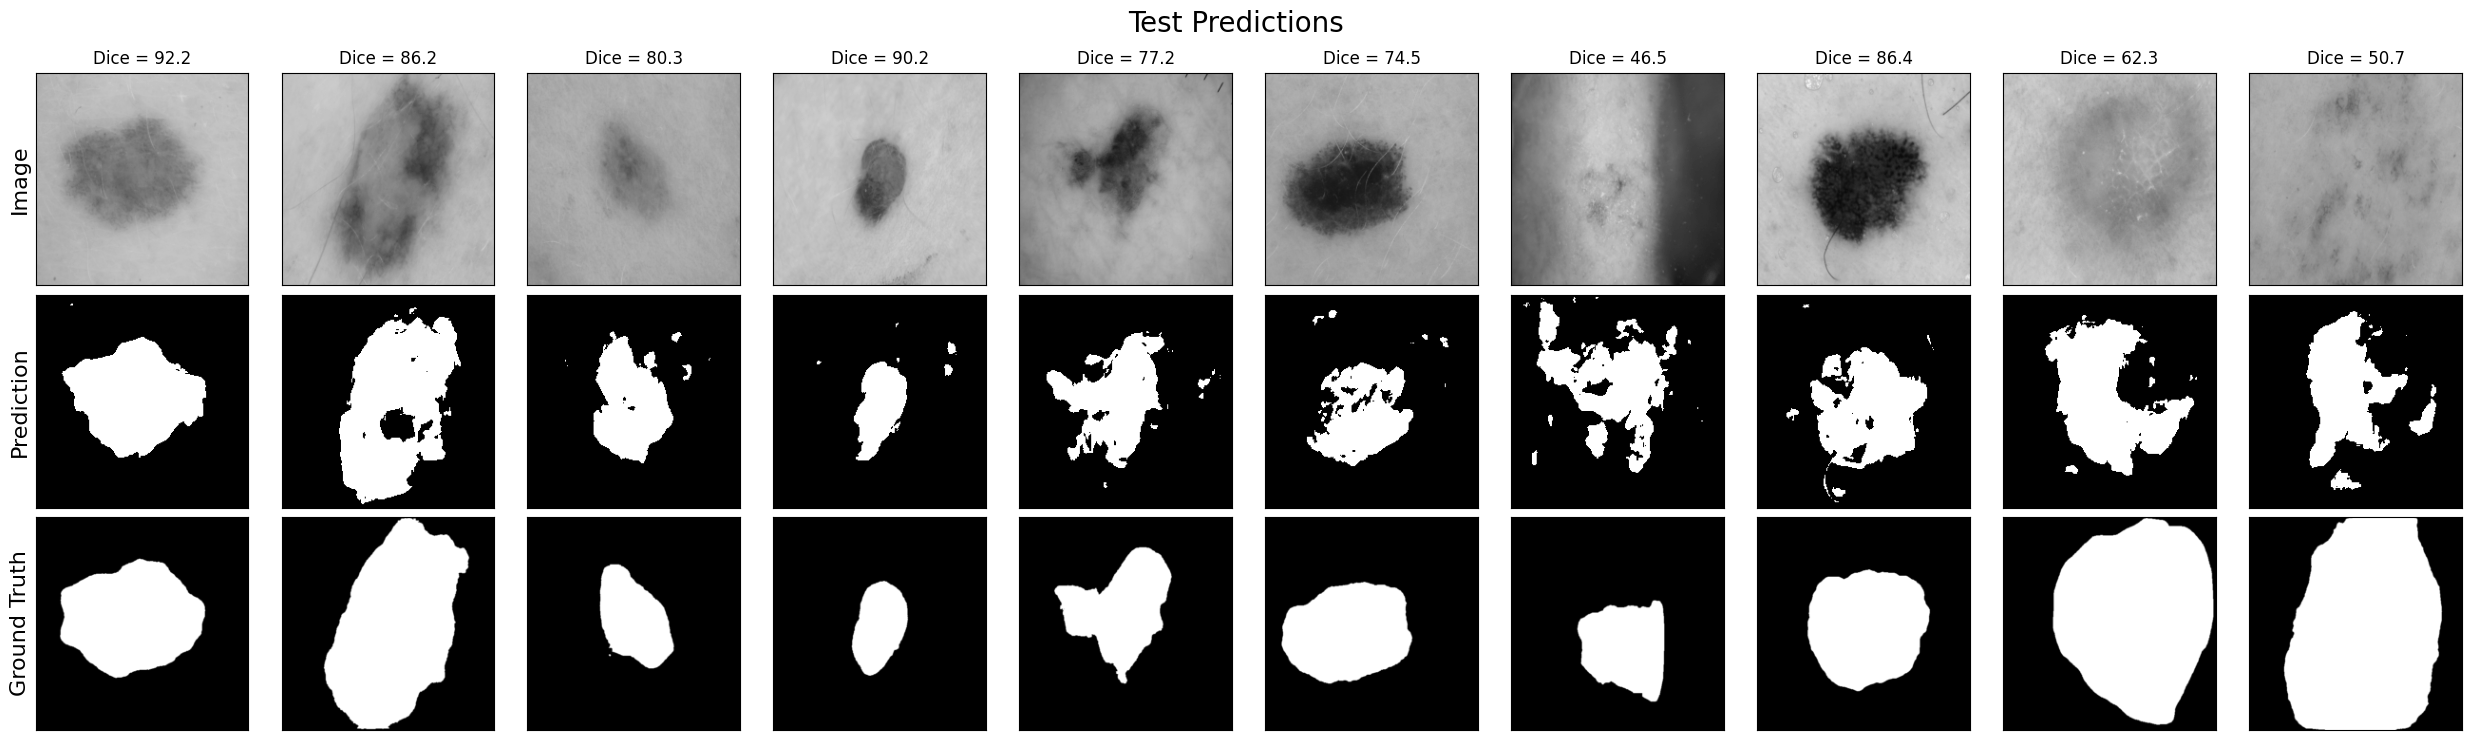

In [71]:
predict(model,d_test,support_images,support_labels,n_predictions=10)